# Simple MCTS
This notebook investigates using MCTS for a single static website where multiple actions have to be done to achieve an answer.

The task is to order a macbook with certain configurations. This website was chosen over others because it does not change upon selecting certain elements, which substantially simplifies testing as a website can simply be cached.

The start domain is [this page](https://www.apple.com/shop/buy-mac/macbook-pro/14-inch-space-gray-apple-m3-chip-with-8-core-cpu-and-10-core-gpu-8gb-memory-512gb) with the prompt "order a macbook pro 14 with 24 gb, 2 tb, fast charging and all available software"

Command to run this:
```
python run_demo.py --task_name openended --model_name openai/gpt-4o-mini --start_url https://www.apple.com/shop/buy-mac/macbook-pro/14-inch-space-gray-apple-m3-chip-with-8-core-cpu-and-10-core-gpu-8gb-memory-512gb
```

## Setup and load cached website

In [477]:
website = "https://www.apple.com/shop/buy-mac/macbook-pro/14-inch-space-gray-apple-m3-chip-with-8-core-cpu-and-10-core-gpu-8gb-memory-512gb"

human_prompt = "order a macbook pro 14 with 24 gb ram, 2 tb, fast charging and all available software"

In [1]:
# ideal actions are:
# ideal_actions = [
#     "click(1007)",  # Select 24GB unified memory
#     "click(1038)",  # Select 2TB SSD storage
#     "click(1061)",  # Select 96W USB-C Power Adapter
#     "click(1112)",  # Select Final Cut Pro software
#     "click(1135)",  # Select Logic Pro software
#     "click(1209)",  # Add to bag
# ]
ideal_actions = [
    'click(1008)',
    'click(1039)',
    'click(1062)',
    'click(1113)',
    'click(1136)',
    'click(1209)'
    ]

In [2]:
txt_file = "../output_example_2.txt"
with open(txt_file, 'r') as file:
    lines = file.readlines()

system_messages = []
prompts = []
actions = []

current_section = None

for line in lines:
    if line.startswith("System Message:"):
        current_section = "System Message"
    elif line.startswith("Prompt:"):
        current_section = "Prompt"
    elif line.startswith("Action:"):
        current_section = "Action"
    else:
        if current_section == "System Message":
            system_messages.append(line)
        elif current_section == "Prompt":
            prompts.append(line)
        elif current_section == "Action":
            actions.append(line)

system_prompt = system_messages[0].split("content='")[-1].strip()
base_prompt = prompts[0].split("content=\'")[-1].strip()
# ideal_actions = actions[:6]

In [3]:
import sys
sys.path.append("../demo_agent")
from agents.legacy.dynamic_prompting import Think, Memory, ActionSpace, Flags

flags=Flags(
    use_html=True,
    use_ax_tree=True,
    use_thinking=True,  # "Enable the agent with a memory (scratchpad)."
    use_error_logs=True,  # "Prompt the agent with the error logs."
    use_memory=False,  # "Enables the agent with a memory (scratchpad)."
    use_history=True,
    use_diff=False,  # "Prompt the agent with the difference between the current and past observation."
    use_past_error_logs=True,  # "Prompt the agent with the past error logs."
    use_action_history=True,  # "Prompt the agent with the action history."
    multi_actions=True,
    action_space="bid",
    use_abstract_example=True,  # "Prompt the agent with an abstract example."
    use_concrete_example=True,  # "Prompt the agent with a concrete example."
    use_screenshot=False,
    enable_chat=True,
    demo_mode="default",
)

think = Think(visible=lambda: flags.use_thinking)
memory = Memory(visible=lambda: flags.use_memory)
action_space = ActionSpace(flags)

def parser(text_answer):
    ans_dict = {}
    try:
        ans_dict.update(think._parse_answer(text_answer))
        ans_dict.update(memory._parse_answer(text_answer))
        ans_dict.update(action_space._parse_answer(text_answer))
    except Exception as e:
        ans_dict['action'] = None
        ans_dict['think'] = None

    return ans_dict, True, ""

/opt/homebrew/anaconda3/envs/agents/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [78]:
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage


with open("../openai_key.txt", "r") as file:
    api_key = file.read().strip()

model = ChatOpenAI(
            model_name="gpt-4o-mini",
            temperature=0.0,
            max_tokens=2_000,
            api_key=api_key
        ).bind(logprobs=True)

## Preliminaries: clean html and build prompts

In [5]:
import re
from html.parser import HTMLParser

class HTMLCleaner(HTMLParser):
    def __init__(self):
        super().__init__()
        self.output = []
        self.tag_stack = []
        self.current_content = []
        self.interactive_elements = {
            'a', 'button', 'input', 'select', 'textarea', 'label', 'fieldset',
            'legend', 'datalist', 'output', 'option', 'optgroup'
        }

    def is_interactive(self, tag, attrs):
        if tag.lower() in self.interactive_elements:
            return True
        return any(attr[0] == 'onclick' for attr in attrs)

    def handle_starttag(self, tag, attrs):
        if tag.lower() == 'img':
            return
        
        is_interactive = self.is_interactive(tag, attrs)
        bid_attr = next((attr for attr in attrs if attr[0] == 'bid'), None)
        
        if bid_attr and not is_interactive:
            bid_attr = None

        self.tag_stack.append((tag, bid_attr, len(self.output)))
        self.current_content.append([])

    def handle_endtag(self, tag):
        if tag.lower() == 'img':
            return

        if self.tag_stack and self.tag_stack[-1][0] == tag:
            start_tag, bid_attr, start_index = self.tag_stack.pop()
            content = ''.join(self.current_content.pop()).strip()

            if content:
                if bid_attr:
                    self.output.insert(start_index, f'<{start_tag} bid="{bid_attr[1]}">')
                else:
                    self.output.insert(start_index, f'<{start_tag}>')
                self.output.append(content)
                self.output.append(f'</{tag}>')

            if self.current_content:
                self.current_content[-1].extend(self.output[start_index:])
                del self.output[start_index:]

    def handle_data(self, data):
        normalized_data = re.sub(r'(\\n|\n|\r)+', '', data)
        normalized_data = re.sub(r'\s+', ' ', normalized_data)
        if self.current_content:
            self.current_content[-1].append(normalized_data)
        else:
            self.output.append(normalized_data)

def clean_html(html_content):
    html_content = html_content.replace('\\n', '\n')
    cleaner = HTMLCleaner()
    cleaner.feed(html_content)
    return ''.join(cleaner.output).strip()

In [6]:
html = base_prompt.split("# ")[4]
c_html = clean_html(html)
len(html), len(c_html)

(288727, 32333)

In [7]:
all([ia[6:10] in c_html for ia in ideal_actions])

True

In [212]:
concrete_example = """
Concrete Example:\\n\\nHere is a concrete example of how to think about next options.
Make sure you follow this structure, but replace the content with your answer. The following example is when you did not take any actions yet:
\\n\\n<think>\\n
Currently I see xxx on the page. Given that I did not take any actions yet, nothing is yet achieved.\\n
1) Nothing

The 5-10 possible next steps to achieve the goal are: 
1) fill in yy to achieve bb
2) show more information for option xx
3) select the configuration for the product
4) click on the field that goes to page xx 
5) go to page yyy by clicking xxx.\\n 
The amount of actions should equal the amount of goals. Now I will predict the corresponding actions for the above goals without writing any further comments. \\n
\\n</think>\\n\\n<action>\\
fill(yyy, zzz)
click(123)
click(456)
click(789)
click(1415)
\\n</action>\\n\\n

Next, there is an example of a concrete example with 3 actions taken so far:
\\n\\n<think>\\n
Currently I see xxx on the page. Now I summarize what happened by my last actions
1) I clicked on click(6543) which does xxx
2) I clicked on click(7543) which expands the list about yyy
3) I filled in field yyy with zzz

Given what I already done, the 5-10 possible next steps to achieve the goal are: 
1) click on the extra memory button 
2) expand the list with bid 2341 
3) fill in field yyy with zzz 
4) click on the field that completes the order 
5) select the option u 
6) click no the home button 
7) finish the task by clicking on the final button.\\n 
The amount of actions should equal the amount of goals. Now I will predict the corresponding actions for the above goals without writing any further comments. \\n
\\n</think>\\n\\n<action>\\
click(648)
click(2341)
fill(yyy, zzz)
click(123)
click(456)
click(789)
click(3214)
</action>\\n\\n
"""

In [ ]:
# 7) return to the latest page 
# 8) select dropdown to search for option yyy 
# 9) click button n for xx

# click(1011)
# click(1213)
# click(1415)

In [213]:
simple_action_space = """Action space:\\n\\1 type of actions are available.\\n\\nclick(bid: int)\\n    Description: Click an element.\\n    Examples:\\n        click(\\\'151\\\')\\n\\n    Multiple actions can be provided at once, but will be executed sequentially without any feedback from the page.\\nExample:\\nfill(\\\'a12\\\', \\\'example with "quotes"\\\')\\nclick(\\\'a51\\\')\\nclick(\\\'48\\\', button=\\\'middle\\\', modifiers=[\\\'Shift\\\'])\\n\\n"""

def build_action_prompt(base_prompt, actions, thoughts):
    base_splits = base_prompt.split("# ")
    # change html obs
    html = base_splits[4][7:]
    base_splits[4] = "HTML:" + clean_html(html)

    hist_split = base_splits[6]
    hist_instruction = hist_split[:-4]
    hist_end = hist_split[-4:]
    new_hist = hist_instruction + " The actions already taken are [" + ", ".join(actions) + "]; Thoughts [" + ", ".join(thoughts) + "]" + hist_end
    base_splits[6] = new_hist
    base_splits[7] = simple_action_space
    base_splits[8] = ""
    base_splits[9] = concrete_example
    new_prompt = "# ".join(base_splits)
    new_prompt += " # Final Instruction: Given that the last actions are: " + ", ".join(actions) + ", what are possible next actions?"
    return new_prompt

In [10]:
# ground truth
actions = []
action_thoughts = []
thoughts = []

new_prompt = build_action_prompt(base_prompt, actions, thoughts)
chat_messages = [
    SystemMessage(content=system_prompt),
    HumanMessage(content=new_prompt+"Think about what to do and then predict all actions at once to complete the task."),
]
out = model.invoke(chat_messages)
ans_dict = parser(out.content)

In [11]:
print(f"Predicted:\n{ans_dict[0]['action']}")
print(f"\nIdeal:\n{ideal_actions}")

Predicted:
click(1008) 
click(1039) 
click(1113) 
click(1136) 
click(1209)

Ideal:
['click(1008)', 'click(1039)', 'click(1062)', 'click(1113)', 'click(1136)', 'click(1209)']


In [55]:
import math
import copy

def get_relevant_tokens(tokens_data, target_string):
    relevant_tokens = []
    remaining = copy.deepcopy(target_string)
    started = False
    
    for token_data in tokens_data:
        if remaining.startswith(token_data['token']):
            started = True
            relevant_tokens.append(token_data)
            remaining = remaining[len(token_data['token']):]
            if not remaining:  # We've found all parts of the target string
                break
        else:
            # case if only a part but not the whole is found
            if started:
                remaining = copy.deepcopy(target_string)
                relevant_tokens = []
                started = False
    
    if remaining:
        print(f"Failed to find all parts of the target string. Remaining: {remaining}")
        relevant_tokens = []

    return relevant_tokens

def get_string_probs(tokens_data, target_string):
    relevant_tokens = get_relevant_tokens(tokens_data, target_string)
    if len(relevant_tokens) == 0:
        return 0., 0.
    combined_logprob = sum(token['logprob'] for token in relevant_tokens)
    combined_probability = math.exp(combined_logprob)
    return combined_logprob, combined_probability

tokens_data = out.response_metadata['logprobs']['content']
target_string = "click(1008)\n"

relevant_tokens = get_relevant_tokens(tokens_data, target_string)

print("Relevant tokens:")
for token in relevant_tokens:
    print(f"Token: {token['token']}, LogProb: {token['logprob']}")

combined_logprob, combined_probability = get_string_probs(tokens_data, target_string)

print(f"\nCombined logprob: {combined_logprob}")
print(f"Combined probability: {combined_probability}")

Failed to find all parts of the target string. Remaining: click(1008)

Relevant tokens:
Failed to find all parts of the target string. Remaining: click(1008)


Combined logprob: 0.0
Combined probability: 0.0


In [188]:
def expand_predict(actions, thoughts):
    new_prompt = build_action_prompt(base_prompt, actions, thoughts)
    chat_messages = [
        SystemMessage(content=system_prompt+" Only predict the next step and not the whole plan at once.  Do not put any comments after an action. Give at minimum 5 and not more than 10 most likely options for the next step, starting with the best one."),
        HumanMessage(content=new_prompt),
    ]
    out = model.invoke(chat_messages)
    tokens_data = out.response_metadata['logprobs']['content']

    ans_dict = parser(out.content)
    thought = ans_dict[0]['think']
    actions = ans_dict[0]['action'].split("\n")

    action_probs = []
    for act_string in actions:
        # target_string = act_string[6:10]
        target_string = act_string + "\n"
        combined_logprob, combined_probability = get_string_probs(tokens_data, target_string)
        action_probs.append(combined_probability)

    return actions, thought, action_probs

In [189]:
actions = ['click(1008)', 'click(1039)', 'click(1062)', 'click(1100)', 'click(1129)']
# actions = []
thoughts = ['Currently, I see the customization options for the 14-inch MacBook Pro on the page. The possible next steps to achieve the goal of ordering the MacBook Pro with the specified configurations are: \n1) click on the radio button for "24GB unified memory" \n2) click on the radio button for "2TB SSD storage" \n3) click on the button to select the "96W USB-C Power Adapter" \n4) click on the button to add "Final Cut Pro" \n5) click on the button to add "Logic Pro" \n6) click on the "Add to Bag" button to proceed with the order \n7) click on the button to check delivery dates \n8) click on the button to check availability for in-store pickup \n9) click on the button to save the configuration for later \n10) click on the button to chat with a Mac Specialist for assistance.\nNow I will predict the corresponding actions for the above goals.',
            'Currently, I see the customization options for the 14-inch MacBook Pro on the page. I have already clicked on the radio button for "24GB unified memory." \n\nGiven what I have already done, the possible next steps to achieve the goal are: \n1) click on the radio button for "2TB SSD storage" \n2) click on the radio button for "96W USB-C Power Adapter" \n3) click on the button to add "Final Cut Pro" \n4) click on the button to add "Logic Pro" \n5) click on the "Add to Bag" button to proceed with the order \n6) click on the button to check delivery dates \n7) click on the button to check availability for in-store pickup \n8) click on the button to save the configuration for later \n9) click on the button to chat with a Mac Specialist for assistance \n10) click on the button to learn more about the memory options.\nNow I will predict the corresponding actions for the above goals.',
            'Currently, I see the customization options for the 14-inch MacBook Pro on the page. Now I summarize what happened by my last actions:\n1) I clicked on the radio button for "24GB unified memory."\n2) I clicked on the radio button for "2TB SSD storage."\n\nGiven what I have already done, the possible next steps to achieve the goal are: \n1) click on the button to select the "96W USB-C Power Adapter" \n2) click on the button to add "Final Cut Pro" \n3) click on the button to add "Logic Pro" \n4) click on the "Add to Bag" button to proceed with the order \n5) click on the button to check delivery dates \n6) click on the button to check availability for in-store pickup \n7) click on the button to save the configuration for later \n8) click on the button to chat with a Mac Specialist for assistance \n9) click on the button to learn more about the power adapter options \n10) click on the button to learn more about the pre-installed software options.\n\nNow I will predict the corresponding actions for the above goals.',
            'Currently, I see the customization options for the 14-inch MacBook Pro on the page. Now I summarize what happened by my last actions:\n1) I clicked on the radio button for "24GB unified memory."\n2) I clicked on the radio button for "2TB SSD storage."\n3) I clicked on the button to select the "96W USB-C Power Adapter."\n\nGiven what I have already done, the possible next steps to achieve the goal are: \n1) click on the button to add "Final Cut Pro" \n2) click on the button to add "Logic Pro" \n3) click on the "Add to Bag" button to proceed with the order \n4) click on the button to check delivery dates \n5) click on the button to check availability for in-store pickup \n6) click on the button to save the configuration for later \n7) click on the button to chat with a Mac Specialist for assistance \n8) click on the button to learn more about the pre-installed software options \n9) click on the button to learn more about the memory options \n10) click on the button to learn more about the power adapter options.\nNow I will predict the corresponding actions for the above goals.',
            'Currently I see the customization options for the 14-inch MacBook Pro on the page. Now I summarize what happened by my last actions:\n1) I clicked on the radio button for "24GB unified memory."\n2) I clicked on the radio button for "2TB SSD storage."\n3) I clicked on the button to select the "96W USB-C Power Adapter."\n4) I clicked on the button to add "Final Cut Pro."\n\nGiven what I have already done, the possible next steps to achieve the goal are: \n1) click on the button to add "Logic Pro" \n2) click on the "Add to Bag" button to proceed with the order \n3) click on the button to check delivery dates \n4) click on the button to check availability for in-store pickup \n5) click on the button to save the configuration for later \n6) click on the button to chat with a Mac Specialist for assistance \n7) click on the button to learn more about the pre-installed software options \n8) click on the button to learn more about the memory options \n9) click on the button to learn more about the power adapter options \n10) click on the button to view the gallery of the MacBook Pro.\n\nNow I will predict the corresponding actions for the above goals.'
            ]
# thoughts = []
actions, thought, action_probs = expand_predict(actions, thoughts)

In [190]:
print(thought)

Currently I see the customization options for the 14-inch MacBook Pro on the page. Now I summarize what happened by my last actions:
1) I clicked on the radio button for "24GB unified memory."
2) I clicked on the radio button for "2TB SSD storage."
3) I clicked on the button to select the "96W USB-C Power Adapter."
4) I clicked on the button to add "Final Cut Pro."
5) I clicked on the button to add "Logic Pro."

Given what I have already done, the 5-10 possible next steps to achieve the goal are: 
1) click on the "Add to Bag" button to proceed with the order 
2) click on the button to check delivery dates 
3) click on the button to check availability for in-store pickup 
4) click on the button to save the configuration for later 
5) click on the button to chat with a Mac Specialist for assistance 
6) click on the button to learn more about the pre-installed software options 
7) click on the button to learn more about the memory options 
8) click on the button to learn more about the po

In [191]:
actions, action_probs

(['click(1209)', 'click(1168)', 'click(1177)', 'click(1150)', 'click(945)'],
 [0.9984979795325685,
  0.9819711837065279,
  0.9999918645699428,
  0.9996503840815936,
  0.9992290739612943])

Log-probs are kinda arbitrary, it seems like the first is quite low whereas the rest is pretty high. It does not really represent the probability of taking the action but rather the probability that this is generated next which seems to be pretty different as click(1008) would be the logically best option.

In [109]:
ideal_actions

['click(1008)',
 'click(1039)',
 'click(1062)',
 'click(1113)',
 'click(1136)',
 'click(1209)']

In [52]:
import re

# Find the position of the bid="1100" in the c_html string
match = re.search(r'bid="1123"', c_html)
if match:
    start = max(match.start() - 50, 0)
    end = min(match.end() + 50, len(c_html))
    context = c_html[start:end]
    print(context)
else:
    print("bid=\"1100\" not found in c_html")

/div></div></div> <div><h3>Logic Pro</h3> <button bid="1123"><::after> Learn\xa0more <span>Logic Pro</span></b


## Build MCTS

In [4]:
# def expand_predict(actions, thoughts):
#     new_actions = [
#         'click(1008)',
#         'click(4351)',
#         'click(1039)',
#         'click(4351)',
#         'click(1062)',
#         'click(2135)',
#         'click(5432)',
#         'click(1113)',
#         'click(1136)',
#         'click(1209)'
#     ]
#     thought = "hi"
#     logprobs = [1.0] * 10
#     return new_actions, thought, logprobs

In [19]:
import random
import copy
import math
import numpy as np
import torch
from torch.distributions import Beta

In [84]:
class Node:
    def __init__(self, actions, thoughts, parent=None, depth=0, dr=None):
        self.actions = actions
        self.thoughts = thoughts
        self.parent = parent
        self.children = []
        self.visits = 0
        self.depth = depth
        self.dr = dr

    def get_initial_rewards(self, n):
        rewards = [max(1 - i * self.dr, 0) for i in range(n)]
        return rewards

class UCBNode(Node):
    def __init__(self, actions, thoughts, parent=None, depth=0, alpha=0.1, dr=None):
        super().__init__(actions, thoughts, parent=parent, depth=depth, dr=dr)
        self.value = np.inf
        self.alpha = alpha

    def expand(self):
        arms, thought, action_probs = expand_predict(self.actions, self.thoughts)
        self.children = [UCBNode(self.actions + [arm],
                                      self.thoughts + [thought],
                                      parent=self,
                                      depth=self.depth+1) for arm in arms]

        if self.dr is not None:
            rewards = self.get_initial_rewards(len(arms))
            for child, reward in zip(self.children, rewards):
                child.update(reward)


    def ucb_score(self, node: Node, total_visits: int) -> float:
        if node.visits == 0:
            return float('inf')
        return (node.value / node.visits) + self.alpha * math.sqrt(2 * math.log(total_visits) / node.visits)

    def select_arm(self, greedy=False) -> Node:
        if self.children is None:
            return None
        
        if greedy:
            scores = [c.visits for c in self.children]
        else:
            scores = [self.ucb_score(c, self.visits) for c in self.children]
        max_score = max(scores)
        max_children = [c for c, s in zip(self.children, scores) if s == max_score]
        return random.choice(max_children)

    def update(self, reward):
        self.visits += 1
        if self.value == np.inf:
            self.value = copy.deepcopy(reward)
        else:
            self.value += copy.deepcopy(reward)

In [136]:
class ThompsonNode(Node):
    def __init__(self, actions, thoughts, parent=None, depth=0, dr=None):
        super().__init__(actions, thoughts, parent=parent, depth=depth, dr=dr)
        self.alpha = 1.0
        self.beta = 1.0

    def expand(self):
        arms, thought, action_probs = expand_predict(self.actions, self.thoughts)
        self.children = [ThompsonNode(self.actions + [arm],
                                      self.thoughts + [thought],
                                      parent=self,
                                      depth=self.depth+1) for arm in arms]
        
        if self.dr is not None:
            rewards = self.get_initial_rewards(len(arms))
            for child, reward in zip(self.children, rewards):
                child.update(reward)

    def select_arm(self, greedy=False):
        if self.children is None:
            return None
        
        if greedy:
            # Greedy selection based on mean of Beta distribution
            means = [child.alpha / (child.alpha + child.beta) for child in self.children]
            child_idx = means.index(max(means))
        else:
            # Thompson sampling
            samples = [Beta(child.alpha, child.beta).sample().item() for child in self.children]
            child_idx = samples.index(max(samples))
        
        return self.children[child_idx]

    def update(self, reward):
        self.visits += 1
        self.alpha += reward
        self.beta += (1 - reward)


class GreedyNode(Node):
    def __init__(self, actions, thoughts, parent=None, depth=0, dr=None):
        super().__init__(actions, thoughts, parent=parent, depth=depth, dr=dr)
        self.value = np.inf

    def expand(self):
        arms, thought, action_probs = expand_predict(self.actions, self.thoughts)
        self.children = [GreedyNode(self.actions + [arm],
                                      self.thoughts + [thought],
                                      parent=self,
                                      depth=self.depth+1) for arm in arms]

    def select_arm(self, greedy=True):
        if self.children is None:
            return None
        
        # always greedy
        child_idx = np.argmax([child.value for child in self.children])
        return self.children[child_idx]

    def update(self, reward):
        self.visits += 1
        if self.value == np.inf:
            self.value = reward
        else:
            self.value += reward

In [93]:
# define tree helper functions
def print_tree(node, indent=""):
    if len(node.actions) > 0:
        print(f"{indent}Action: {node.actions[-1]}")
        print(f"{indent}Value: {node.value}")
    print(f"{indent}Children: {len(node.children)}")
    for child in node.children:
        print_tree(child, indent + "  ")

# create all possible trajectories of actions from tree
def get_trajectories(node):
    if not node.children:
        return [[node.actions]]
    
    trajectories = []
    for child in node.children:
        child_trajectories = get_trajectories(child)
        for trajectory in child_trajectories:
            trajectories.append([node.actions] + trajectory)
    
    trajectories = [t[-1] for t in trajectories]
    return trajectories

In [94]:
def select(node: Node) -> Node:
    while node.children:
        node = node.select_arm()
    return node

def backpropagate(node: Node, reward: float):
    while node:
        node.update(reward)
        node = node.parent

In [123]:
# 'click(1100)', 'click(1129)' are also correct for step 4 and 5
all_ideal_actions = [
    ['click(1008)',],
    ['click(1039)',],
    ['click(1062)',],
    ['click(1113)', 'click(1100)'],
    ['click(1136)', 'click(1129)', 'click(1123)'],
    ['click(1209)',],
]

def get_t_value(trajectory):
    score = 1
    for a, b in zip(trajectory, all_ideal_actions):
        if not a.strip() in b:
            score = 0
    return score


t = ['click(1008)', 'click(1038)', 'click(1062)', 'click(1112)\nclick(1136)']
t2 = ['click(1008)', 'click(1039)', 'click(1062)', 'click(1113)', 'click(1123)']
get_t_value(ideal_actions), get_t_value(t), get_t_value(t2)

(1, 0, 1)

In [124]:
from tqdm import tqdm

def mcts_like(root, max_depth, max_iters):
    expand_count = 0
    for iter_idx in tqdm(range(max_iters)):
        selected_node = select(root)

        # expansion + simulation
        remaining_depth = max_depth - selected_node.depth

        value = get_t_value(selected_node.actions)
        backpropagate(selected_node, value)

        if remaining_depth > 0 and value != 0.0:
            for _ in range(remaining_depth):
                selected_node.expand()
                expand_count += 1
                selected_node = select(selected_node)

                value = get_t_value(selected_node.actions)
                backpropagate(selected_node, value)

                if value == 0.0:
                    break

        if value == 1.0 and selected_node.depth >= max_depth:
            print(f"Success at iter {iter_idx}")
            break

    return root, iter_idx, expand_count

In [142]:
max_depth = 6
max_iters = 1_000
actions = []
thoughts = []
root = ThompsonNode(actions, thoughts, dr=None)
root, iter_idx, expand_count = mcts_like(root, max_depth, max_iters)

  4%|▍         | 43/1000 [00:27<10:15,  1.55it/s] 

Success at iter 43


In [144]:
best_c = copy.deepcopy(root)
while best_c.children:
    print([c.actions[-1] for c in best_c.children])
    # print([c.value for c in best_c.children])
    # print([c.beta for c in best_c.children])
    # print([c.thoughts[-1] for c in best_c.children])
    print([c.visits for c in best_c.children])
    best_c = best_c.select_arm(greedy=True)
print(f"\nBest trajectory:{best_c.actions}\nScore: {get_t_value(best_c.actions)}")

['click(1008) ', 'click(1039) ', 'click(1062) ', 'click(1113) ', 'click(1136) ', 'click(1209)']
[24, 5, 3, 5, 6, 6]
['click(1039)']
[23]
['click(1062)', 'click(1113)', 'click(1136)', 'click(1209)']
[11, 3, 3, 5]
['click(1100)', 'click(1123)', 'click(1209)']
[6, 3, 1]
['click(1113)', 'click(1136)', 'click(1209)']
[2, 2, 1]
['click(1113)', 'click(1136)', 'click(1209)']
[0, 0, 1]

Best trajectory:['click(1008) ', 'click(1039)', 'click(1062)', 'click(1100)', 'click(1136)', 'click(1209)']
Score: 1


In [226]:
from collections import defaultdict

max_depth = 6
max_iters = 1_000
dr = 0.2 # the reward decay rate for action positions

n_experiments = 10

n_iters_to_success = defaultdict(list)
expand_counts = defaultdict(list)

for _ in range(n_experiments):
    classes = [UCBNode, GreedyNode, ThompsonNode]
    for cls in classes:
        print(cls.__name__)
        root = cls([], [], dr=dr)
        root, iter_idx, expand_count = mcts_like(root, max_depth, max_iters)
        n_iters_to_success[cls.__name__].append(iter_idx)
        expand_counts[cls.__name__].append(expand_count)

UCBNode


  2%|▏         | 19/1000 [00:28<24:26,  1.49s/it] 


Success at iter 19
GreedyNode


  2%|▏         | 16/1000 [00:26<27:19,  1.67s/it] 


Success at iter 16
ThompsonNode


 32%|███▏      | 321/1000 [00:37<01:19,  8.58it/s]


Success at iter 321
UCBNode


  1%|          | 11/1000 [00:37<56:46,  3.44s/it] 


Success at iter 11
GreedyNode


  2%|▏         | 20/1000 [00:32<26:30,  1.62s/it] 


Success at iter 20
ThompsonNode


  6%|▌         | 62/1000 [00:37<09:20,  1.67it/s] 


Success at iter 62
UCBNode


100%|██████████| 1000/1000 [00:16<00:00, 60.73it/s]


GreedyNode


  2%|▏         | 22/1000 [00:46<34:33,  2.12s/it] 


Success at iter 22
ThompsonNode


 22%|██▏       | 222/1000 [00:33<01:56,  6.67it/s]


Success at iter 222
UCBNode


  2%|▏         | 21/1000 [00:34<26:34,  1.63s/it] 


Success at iter 21
GreedyNode


  2%|▏         | 17/1000 [00:34<33:15,  2.03s/it] 


Success at iter 17
ThompsonNode


 16%|█▋        | 164/1000 [00:36<03:07,  4.45it/s]


Success at iter 164
UCBNode


  3%|▎         | 26/1000 [00:37<23:24,  1.44s/it] 


Success at iter 26
GreedyNode


  2%|▏         | 17/1000 [00:32<31:12,  1.91s/it] 


Success at iter 17
ThompsonNode


 22%|██▏       | 217/1000 [00:39<02:21,  5.55it/s]


Success at iter 217
UCBNode


  2%|▏         | 16/1000 [00:51<52:27,  3.20s/it] 


Success at iter 16
GreedyNode


  2%|▏         | 19/1000 [00:37<32:31,  1.99s/it] 


Success at iter 19
ThompsonNode


100%|██████████| 1000/1000 [00:31<00:00, 31.30it/s]


UCBNode


  2%|▏         | 19/1000 [00:44<38:07,  2.33s/it] 


Success at iter 19
GreedyNode


  2%|▏         | 18/1000 [00:39<36:18,  2.22s/it] 


Success at iter 18
ThompsonNode


 18%|█▊        | 175/1000 [00:35<02:48,  4.89it/s]


Success at iter 175
UCBNode


100%|██████████| 1000/1000 [00:32<00:00, 30.83it/s]


GreedyNode


  2%|▏         | 21/1000 [00:31<24:28,  1.50s/it] 


Success at iter 21
ThompsonNode


  7%|▋         | 72/1000 [00:27<05:54,  2.62it/s] 


Success at iter 72
UCBNode


  2%|▏         | 20/1000 [00:34<28:24,  1.74s/it] 


Success at iter 20
GreedyNode


  2%|▏         | 17/1000 [00:33<31:53,  1.95s/it] 


Success at iter 17
ThompsonNode


100%|██████████| 1000/1000 [00:10<00:00, 91.17it/s]


UCBNode


  2%|▏         | 18/1000 [00:42<38:52,  2.38s/it] 


Success at iter 18
GreedyNode


100%|██████████| 1000/1000 [00:24<00:00, 40.47it/s]


ThompsonNode


 19%|█▉        | 191/1000 [00:27<01:57,  6.90it/s]

Success at iter 191


UCB proportion of successes: 0.8
Greedy proportion of successes: 0.9
Thompson proportion of successes: 0.8


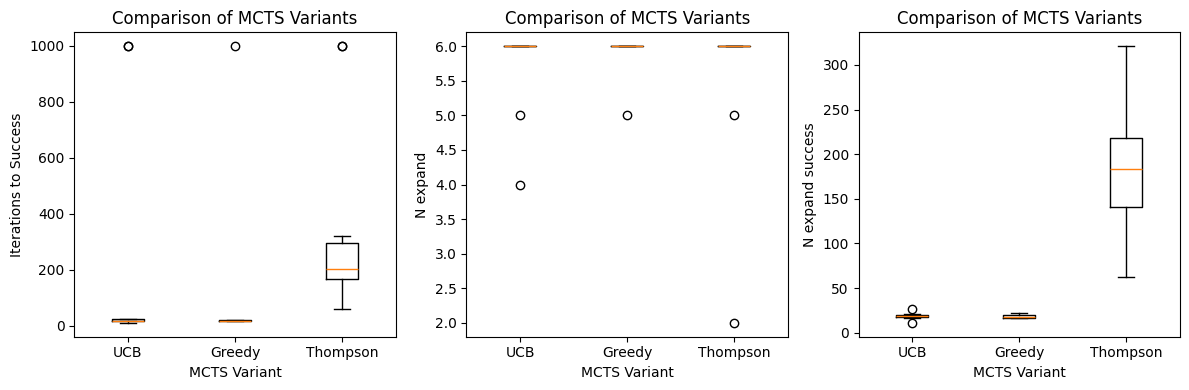

In [227]:
import matplotlib.pyplot as plt

# Create a list of results for boxplot
n_iter_list = list(n_iters_to_success.values())
expand_list = list(expand_counts.values())
labels = ['UCB', 'Greedy', 'Thompson']

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].boxplot(n_iter_list, tick_labels=labels)
axs[0].set_xlabel('MCTS Variant')
axs[0].set_ylabel('Iterations to Success')
axs[0].set_title('Comparison of MCTS Variants')

axs[1].boxplot(expand_list, tick_labels=labels)
axs[1].set_xlabel('MCTS Variant')
axs[1].set_ylabel('N expand')
axs[1].set_title('Comparison of MCTS Variants')

success_n_iter_list = []
for n_iter, expand, l in zip(n_iter_list, expand_list, labels):
    successes = [n for n, x in zip(n_iter, expand) if x >= 6 and n < max_iters - 1]
    print(f"{l} proportion of successes: {len(successes) / len(n_iter)}")
    success_n_iter_list.append(successes)
axs[2].boxplot(success_n_iter_list, tick_labels=labels)
axs[2].set_xlabel('MCTS Variant')
axs[2].set_ylabel('N expand success')
axs[2].set_title('Comparison of MCTS Variants')

plt.tight_layout()
plt.show()

In [223]:
dr = 0.2
root = ThompsonNode([], [], dr=dr)
root, iter_idx, expand_count = mcts_like(root, max_depth, max_iters)

  3%|▎         | 34/1000 [00:35<16:42,  1.04s/it] 

Success at iter 34


In [224]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta

def plot_beta_distribution(node, ax, num_points=1000):
    x = np.linspace(0, 1, num_points)
    y = beta.pdf(x, node.alpha, node.beta)
    
    ax.plot(x, y, lw=2, alpha=0.6, label=node.actions[-1])
    ax.set_title(f'Beta Distribution (depth={node.depth})') # (α={node.alpha:.2f}, β={node.beta:.2f})')
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1.)

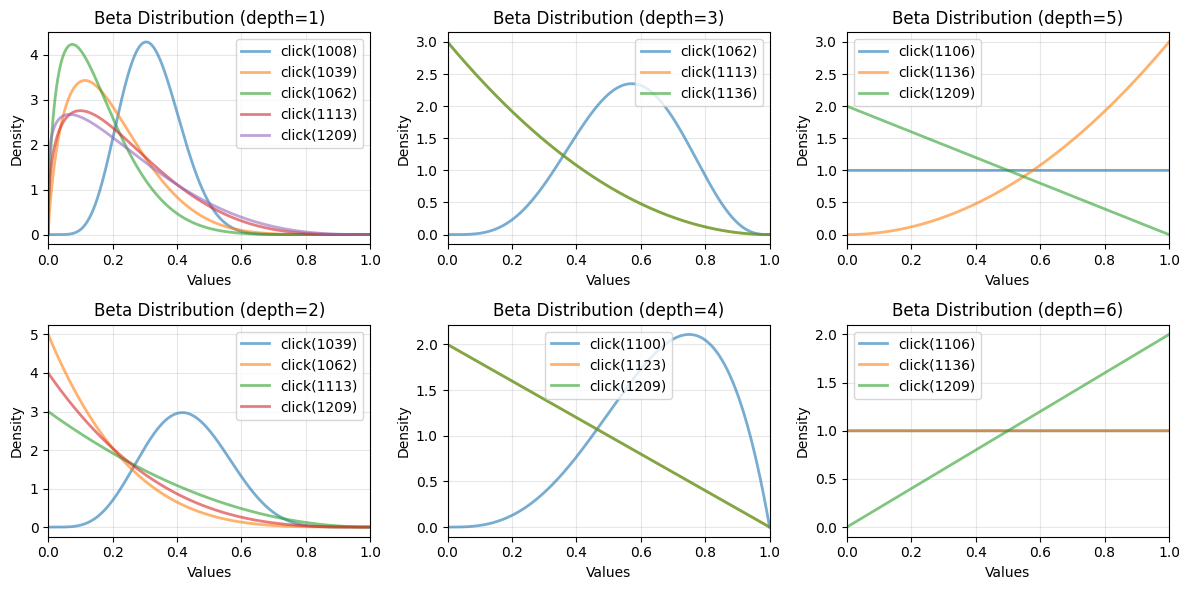

In [225]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

best_c = copy.deepcopy(root)

depth_idx = 0
while best_c.children:
    for c in best_c.children:
        idx_x = depth_idx % 2
        idx_y = depth_idx // 2
        plot_beta_distribution(c, axs[idx_x, idx_y], num_points=5000)
    best_c = best_c.select_arm(greedy=True)
    depth_idx += 1

plt.tight_layout()
plt.show()

In [211]:
best_c = copy.deepcopy(root)
while best_c.children:
    print([c.actions[-1] for c in best_c.children])
    print([c.thoughts[-1] for c in best_c.children])
    # print([c.beta for c in best_c.children])
    print([c.visits for c in best_c.children])
    best_c = best_c.select_arm(greedy=True)
print(f"\nBest trajectory:{best_c.actions}\nScore: {get_t_value(best_c.actions)}")

['click(1008)', 'click(1039)', 'click(1062)', 'click(1113)', 'click(1136)', 'click(1209)']
['Currently, I see the customization options for the 14-inch MacBook Pro on the page. Given that I have not taken any actions yet, nothing is yet achieved.\n\nThe 5-10 possible next steps to achieve the goal are: \n1) select the 24GB unified memory option \n2) select the 2TB SSD storage option \n3) select the 96W USB-C Power Adapter option \n4) add Final Cut Pro to the order \n5) add Logic Pro to the order \n6) click on the "Add to Bag" button to proceed with the order \n7) check delivery dates \n8) save the configuration for later \n9) chat with a Mac Specialist for assistance.\n\nNow I will predict the corresponding actions for the above goals without writing any further comments.', 'Currently, I see the customization options for the 14-inch MacBook Pro on the page. Given that I have not taken any actions yet, nothing is yet achieved.\n\nThe 5-10 possible next steps to achieve the goal are: \n1